<a href="https://colab.research.google.com/github/LeonardoKoide/PucTSP2024.1/blob/main/Trablho_TSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - TSP 20 cidades SP usando 2 OPT solution


## Donwloads/ Imports

In [ ]:
pip install pulp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 60.5 MB/s eta 0:00:00


In [ ]:

!pip install numpy


In [ ]:
!pip install random2==1.0.1

  Preparing metadata (setup.py) ... done
  Created wheel for random2: filename=random2-1.0.1-py3-none-any.whl size=12043 sha256=0dd5828a16709cc144892ba52168670faefc443d45e3010b617bea0d929fd7a0
  Stored in directory: /root/.cache/pip/wheels/61/1f/84/8713326a151c1638e7a00202e4074b46e839d22b7d22f8400f
Successfully built random2


In [ ]:
pip install py2opt

In [ ]:
pip install folium

In [ ]:
import random
import time
from folium import Map, PolyLine, LayerControl, Marker, Popup
from py2opt.solver import Solver
import geopy.distance as geodist
import numpy as np

## Mudancas no py2ot

In [ ]:


class RouteFinder:
    def __init__(self, dist_matrix, city_coords, city_names, num_iterations=5, enable_writer=False, method='py2opt', return_to_start=False, is_verbose=True):
        self.dist_matrix = dist_matrix
        self.num_iterations = num_iterations
        self.return_to_start = return_to_start
        self.enable_writer = enable_writer
        self.city_names = city_names
        self.is_verbose = is_verbose
        self.distances_per_iter = []  # List to store distances for plotting
        self.city_coords = city_coords  # City coordinates (latitude, longitude)
        self.routes_per_iter = []  # List to store routes from each iteration

    def solve(self):
        start_time_ms = round(time.time() * 1000)
        elapsed_time_ms = 0
        current_iter = 0
        optimal_distance = float('inf')
        optimal_route = []

        while current_iter < self.num_iterations:
            total_cities = len(self.dist_matrix)
            if self.is_verbose:
                print(f"{elapsed_time_ms} msec")
            random_route = [0] + random.sample(range(1, total_cities), total_cities - 1) + [0]
            solver = Solver(self.dist_matrix, random_route)
            improved_route, improved_distance, route_distances = solver.two_opt()

            if improved_distance < optimal_distance:
                optimal_distance = improved_distance
                optimal_route = improved_route

            self.routes_per_iter.append(improved_route.copy())  # Store route for each iteration
            self.distances_per_iter.append(optimal_distance)
            elapsed_time_ms = round(time.time() * 1000) - start_time_ms
            current_iter += 1

        if self.enable_writer:
            self.writer(optimal_route, optimal_distance, self.city_names)

        if self.city_names:
            optimal_route = [self.city_names[i] for i in optimal_route]
        return optimal_distance, optimal_route

    @staticmethod
    def writer(optimal_route, optimal_distance, city_names):
        with open("results.txt", "w+") as f:
            for i in optimal_route:
                f.write(f"{city_names[i]}\n")
            f.write(str(optimal_distance))

    def create_initial_map(self):
        start_lat = self.city_coords[0][0]
        start_lng = self.city_coords[0][1]
        return Map(location=[start_lat, start_lng], zoom_start=8)

    def plot_best_route(self):
        map_obj = self.create_initial_map()

        final_route = self.routes_per_iter[-1]
        final_polyline = PolyLine(
            locations=[[self.city_coords[j][0], self.city_coords[j][1]] for j in final_route],
            color='red',
            weight=3,
            opacity=0.8,
            tooltip=f'Best Route: Distance {self.distances_per_iter[-1]:.2f} km'
        )
        final_polyline.add_to(map_obj)

        for name, coordinates in zip(self.city_names, self.city_coords):
            Marker(
                location=(coordinates[0], coordinates[1]),
                popup=Popup(name, parse_html=True)
            ).add_to(map_obj)

        LayerControl().add_to(map_obj)
        return map_obj

def calculate_distance_matrix(city_coords):
    total_cities = len(city_coords)
    dist_matrix = np.zeros((total_cities, total_cities))

    for i in range(total_cities):
        for j in range(total_cities):
            if i != j:
                dist_matrix[i][j] = geodist.distance(city_coords[i], city_coords[j]).km
    return dist_matrix

## Problema

In [ ]:


city_coords_dict = {
    "São Paulo": (-23.550520, -46.633308),
    "Ribeirão Preto": (-21.169956, -47.809879),
    "Campinas": (-22.909938, -47.062633),
    "São José do Rio Preto": (-20.819000, -49.379700),
    "Bauru": (-22.324569, -49.058695),
    "Santos": (-23.960834, -46.333357),
    "Presidente Prudente": (-22.121944, -51.392500),
    "Sorocaba": (-23.501528, -47.452626),
    "São José dos Campos": (-23.223701, -45.900907),
    "Taubaté": (-23.026392, -45.555713),
    "Marília": (-22.217067, -49.950065),
    "Araraquara": (-21.784735, -48.178104),
    "Piracicaba": (-22.733878, -47.647604),
    "Franca": (-20.535206, -47.403938),
    "Jundiaí": (-23.185600, -46.897800),
    "Barretos": (-20.553135, -48.569768),
    "Itu": (-23.264712, -47.299999),
    "Botucatu": (-22.883504, -48.443375),
    "Americana": (-22.739131, -47.331210),
    "Limeira": (-22.566661, -47.397031)
}

# Convert dictionary to lists
city_names = list(city_coords_dict.keys())
city_coords = list(city_coords_dict.values())

# Calculate distance matrix
dist_matrix = calculate_distance_matrix(city_coords)

# Number of iterations
num_iterations = 10

# Create an instance of RouteFinder
route_finder = RouteFinder(dist_matrix, city_coords, city_names, num_iterations)

# Solve TSP
optimal_distance, optimal_route = route_finder.solve()

# Plot the best route on a map
map_obj = route_finder.plot_best_route()

print(optimal_distance)
print(optimal_route)

0 msec
3 msec
6 msec
8 msec
10 msec
13 msec
17 msec
19 msec
21 msec
24 msec
1763.01
['São Paulo', 'Santos', 'São José dos Campos', 'Taubaté', 'Campinas', 'Americana', 'Limeira', 'Araraquara', 'Ribeirão Preto', 'Franca', 'Barretos', 'São José do Rio Preto', 'Presidente Prudente', 'Marília', 'Bauru', 'Botucatu', 'Piracicaba', 'Sorocaba', 'Itu', 'Jundiaí', 'São Paulo']


In [ ]:
# Create an instance of RouteFinder
route_finder = RouteFinder(dist_matrix, city_coords, city_names, num_iterations)

# Solve TSP
optimal_distance, optimal_route = route_finder.solve()

# Plot the best route on a map
map_obj = route_finder.plot_best_route()

print(optimal_distance)
print(optimal_route)

0 msec
3 msec
6 msec
8 msec
11 msec
14 msec
16 msec
18 msec
20 msec
22 msec
1746.61
['São Paulo', 'Santos', 'São José dos Campos', 'Taubaté', 'Campinas', 'Americana', 'Limeira', 'Piracicaba', 'Araraquara', 'Ribeirão Preto', 'Franca', 'Barretos', 'São José do Rio Preto', 'Presidente Prudente', 'Marília', 'Bauru', 'Botucatu', 'Sorocaba', 'Itu', 'Jundiaí', 'São Paulo']


In [ ]:

map_obj


## Outros modelos

In [ ]:
a=[
[0,42.53,   52.21,  9.97,   5.61,   17.35,  42.69,  32.97,  35.77,  153.09  ,39.85, 57.6,   58.83,  67.15,  84.46,  33.34,  55.6,   32.43,  77.4,   58.6],
[42.53, 0,  9.89,   33.7,   37.09,  55.46,  6.89,   11.08,  70.38,  138.58, 47.5,   100.13, 64.8    ,107.4, 123.81, 73.02,  93.26,  14.47,  119.91, 93.61],
[52.21, 9.89,   0,  43.55,  46.71,  64.44,  13.58,  20.84,  80.13,  134.67, 52.38,  109.76, 67.91,  117.29, 133.67, 81.94,  101.6,  24.25,  129.94, 102.26],
[9.97   , 33.7, 43.55,  0,  6.49,   26.73,  33.71,  23.53,  39.3    ,152.85,    41.87,  66.86,  61.69,  74.14,  90.98,  43.25,  65.38,  26.58,  86.74,  62.84],
[5.61   ,37.09, 46.71,  6.49,   0,20.57,    37.56,  27.83,40.27,    149.5,  37.12,  63.05,  56.66,  72.66,  89.9    ,37.53, 59.38,  26.91,  82.82,63.5],
[17.35  ,55.46, 64.44,  26.73,  20.57,  0,  57.1,   47.51,  42.7,   147.63, 34.78,  47.8,   50.41,  64.3,   82.1,   17.55,  38.84,  41.41,  66.67,  62.47],
[42.69  ,6.89,  13.58,  33.17,  37.56,  57.1,   0   ,9.73,  67.53,  145.39, 52.88,  100.03, 70.8,   105.46, 121.45, 74.59,  95.56,  22.6    ,119.9, 90.38],
[32.97  ,11.08  ,20.84, 23.53,  27.83,  47.51,  9.73,   0   ,59.32, 145.68, 46.56,  90.38,  65.5    ,96.57, 112.86, 64.95,  86.1,   17.31,  110.24, 82.53],
[35.77  ,70.38, 80.13   ,39.3,  40.27,  42.7,   67.53,  59.32,  0   ,188.4, 74.67   ,46.11, 92.42,  39.4    ,54.17, 46.27,  65.46,  65.87,  63.83,  23.57],
[153.09,    138.58, 134.67, 152.85, 149.5   ,147.63,    145.39, 145.68, 118.4   ,0  ,113.76,    186.2   ,97.58, 209.96, 227.42, 154.3,  154.54, 130.03, 198.68, 209.91],
[39.85, 47.5    ,52.38, 41.87,  37.12,  37.78,  52.88,  46.56,  74.67,  113.76, 0   ,79.86, 19.96,  98.98,  116.77, 46.28,  58.23,  30.28,  96.92,  96.29],
[57.6   ,100.13,    109.76, 66.86,  63.05,  47.8,   100.03, 90.38,  46.11,  186.2   ,79.86, 0   ,90.1,  28.59,  43.31,  33.63,  34.67,  88.35,  19.89,  45.73],
[56.83, 64.8    ,67.91, 61.69,  56.66,  50.41,  70.8    ,65.5   ,92.42, 97.58,  19.96,  90.1    ,0, 112.53, 130.11, 57.17,  62.2    ,48.5   ,104.9  ,112.88],
[67.15, 107.4   ,117.29 ,74.14, 72.66,  64.3    ,105.46,    96.57,  39.4,   209.96, 98.98,  28.59,  112.53, 0,  17.8,   55.74,  62.76,  99.57,  34.74,  24.68],
[84.46, 123.81, 133.67, 90.98,  89.9    ,82.1,  121.45, 112.86, 54.17,  227.42, 116.77, 43.31,  130.11, 17.8    ,0  ,73.12, 77.97,  116.79, 42.17,  33.98],
[33.34, 73.02,  81.94,  43.25,  37.53,  17.55,  74.59,  74.59,  46.27,  154.3   ,46.28, 33.63,  57.17,  55.74,  71.12,  0,  22.55,  58.62,  50.98,  60.7],
[55.6   ,93.26  ,101.6  ,65.38, 59.38,  38.84,  95.56,  86.1    ,65.46, 154.54, 58.23,  34.67,  62.2    ,62.76, 77.97,  22.55,  0   ,77.56, 44.14,  74.95],
[32.43, 17.47,  24.25,  26.58,  26.91,  41.41,  22.6    ,17.31, 65.87,  130.03, 30.28,  88.35,  48.5    ,99.57, 116.79, 58.62,  77.56,  0,  107.72, 89.41],
[77.4   ,119.91,    129.49, 86.74,  82.82,  66.67,  119.9,  110.24, 63.83,  198.68, 96.92,  19.89,  104.9   ,34.74, 42.17,  50.98,  44.14,  107.72, 0,  57.83],
[58.69,93.61,   103.26, 62.84,  63.5    ,62.47, 90.38,  82.53   ,23.57, 209.91, 96.29,  45.73,  112.88, 24.68   ,33.98  ,60.7,  74.95,  86.41,  57.83,0]
]

In [ ]:
a=[
[0,42.53,   52.21,  9.97,   5.61,   17.35,  42.69,  32.97,  35.77,  153.09  ,39.85, 57.6,   58.83,  67.15,  84.46,  33.34,  55.6,   32.43,  77.4,   58.6],
[42.53, 0,  9.89,   33.7,   37.09,  55.46,  6.89,   11.08,  70.38,  138.58, 47.5,   100.13, 64.8    ,107.4, 123.81, 73.02,  93.26,  14.47,  119.91, 93.61],
[52.21, 9.89,   0,  43.55,  46.71,  64.44,  13.58,  20.84,  80.13,  134.67, 52.38,  109.76, 67.91,  117.29, 133.67, 81.94,  101.6,  24.25,  129.94, 102.26],
[9.97   , 33.7, 43.55,  0,  6.49,   26.73,  33.71,  23.53,  39.3    ,152.85,    41.87,  66.86,  61.69,  74.14,  90.98,  43.25,  65.38,  26.58,  86.74,  62.84],
[5.61   ,37.09, 46.71,  6.49,   0,20.57,    37.56,  27.83,40.27,    149.5,  37.12,  63.05,  56.66,  72.66,  89.9    ,37.53, 59.38,  26.91,  82.82,63.5],
[17.35  ,55.46, 64.44,  26.73,  20.57,  0,  57.1,   47.51,  42.7,   147.63, 34.78,  47.8,   50.41,  64.3,   82.1,   17.55,  38.84,  41.41,  66.67,  62.47],
[42.69  ,6.89,  13.58,  33.17,  37.56,  57.1,   0   ,9.73,  67.53,  145.39, 52.88,  100.03, 70.8,   105.46, 121.45, 74.59,  95.56,  22.6    ,119.9, 90.38],
[32.97  ,11.08  ,20.84, 23.53,  27.83,  47.51,  9.73,   0   ,59.32, 145.68, 46.56,  90.38,  65.5    ,96.57, 112.86, 64.95,  86.1,   17.31,  110.24, 82.53],
[35.77  ,70.38, 80.13   ,39.3,  40.27,  42.7,   67.53,  59.32,  0   ,188.4, 74.67   ,46.11, 92.42,  39.4    ,54.17, 46.27,  65.46,  65.87,  63.83,  23.57],
[153.09,    138.58, 134.67, 152.85, 149.5   ,147.63,    145.39, 145.68, 118.4   ,0  ,113.76,    186.2   ,97.58, 209.96, 227.42, 154.3,  154.54, 130.03, 198.68, 209.91],
[39.85, 47.5    ,52.38, 41.87,  37.12,  37.78,  52.88,  46.56,  74.67,  113.76, 0   ,79.86, 19.96,  98.98,  116.77, 46.28,  58.23,  30.28,  96.92,  96.29],
[57.6   ,100.13,    109.76, 66.86,  63.05,  47.8,   100.03, 90.38,  46.11,  186.2   ,79.86, 0   ,90.1,  28.59,  43.31,  33.63,  34.67,  88.35,  19.89,  45.73],
[56.83, 64.8    ,67.91, 61.69,  56.66,  50.41,  70.8    ,65.5   ,92.42, 97.58,  19.96,  90.1    ,0, 112.53, 130.11, 57.17,  62.2    ,48.5   ,104.9  ,112.88],
[67.15, 107.4   ,117.29 ,74.14, 72.66,  64.3    ,105.46,    96.57,  39.4,   209.96, 98.98,  28.59,  112.53, 0,  17.8,   55.74,  62.76,  99.57,  34.74,  24.68],
[84.46, 123.81, 133.67, 90.98,  89.9    ,82.1,  121.45, 112.86, 54.17,  227.42, 116.77, 43.31,  130.11, 17.8    ,0  ,73.12, 77.97,  116.79, 42.17,  33.98],
[33.34, 73.02,  81.94,  43.25,  37.53,  17.55,  74.59,  74.59,  46.27,  154.3   ,46.28, 33.63,  57.17,  55.74,  71.12,  0,  22.55,  58.62,  50.98,  60.7],
[55.6   ,93.26  ,101.6  ,65.38, 59.38,  38.84,  95.56,  86.1    ,65.46, 154.54, 58.23,  34.67,  62.2    ,62.76, 77.97,  22.55,  0   ,77.56, 44.14,  74.95],
[32.43, 17.47,  24.25,  26.58,  26.91,  41.41,  22.6    ,17.31, 65.87,  130.03, 30.28,  88.35,  48.5    ,99.57, 116.79, 58.62,  77.56,  0,  107.72, 89.41],
[77.4   ,119.91,    129.49, 86.74,  82.82,  66.67,  119.9,  110.24, 63.83,  198.68, 96.92,  19.89,  104.9   ,34.74, 42.17,  50.98,  44.14,  107.72, 0,  57.83],
[58.69,93.61,   103.26, 62.84,  63.5    ,62.47, 90.38,  82.53   ,23.57, 209.91, 96.29,  45.73,  112.88, 24.68   ,33.98  ,60.7,  74.95,  86.41,  57.83,0]
]

In [ ]:
import random;import math
class ResfriamentoMetal:
    def __init__(self, matriz_distancias, temperatura_inicial=100000, taxa_resfriamento=0.999, max_iteracoes=10000):
        self.matriz_distancias = matriz_distancias
        self.n_cidades = len(matriz_distancias)
        self.temperatura = temperatura_inicial
        self.taxa_resfriamento = taxa_resfriamento
        self.max_iteracoes = max_iteracoes
    def avaliar(self, solucao):
        distancia = 0
        for i in range(self.n_cidades - 1):
            distancia += self.matriz_distancias[solucao[i]][solucao[i+1]]
        distancia += self.matriz_distancias[solucao[-1]][solucao[0]]
        return distancia
    def aceitar_mudanca(self, delta_energia):
        return delta_energia < 0 or random.random() < math.exp(-delta_energia / self.temperatura)
    def resfriar(self):
        self.temperatura *= self.taxa_resfriamento
    def busca(self):
       while True:
        melhor_solucao = list(range(self.n_cidades))
        melhor_distancia = self.avaliar(melhor_solucao)
        for _ in range(self.max_iteracoes):
            i, j = sorted(random.sample(range(self.n_cidades), 2))
            vizinho = melhor_solucao[:i] + list(reversed(melhor_solucao[i:j+1])) + melhor_solucao[j+1:]
            vizinho_distancia = self.avaliar(vizinho)
            delta_energia = vizinho_distancia - melhor_distancia
            if self.aceitar_mudanca(delta_energia):
                melhor_solucao = vizinho[:]
                melhor_distancia = vizinho_distancia
            self.resfriar()
        if melhor_distancia < 570:
         break
       return melhor_solucao, melhor_distancia
matriz= a
rm = ResfriamentoMetal(matriz)
melhor_solucao, melhor_distancia = rm.busca()
n= ["São Caetano do Sul" if item == 0 else "Santos" if item == 1 else "Guarujá" if item==2 else "São Bernardo do Campo" if item==3 else "Santo André" if item==4 else "Guarulhos" if item==5 else "São Vicente" if item==6 else "Cubatão" if item==7 else "Cotia" if item==8 else "Ubatuba" if item==9 else "Mogi das Cruzes" if item==10 else "Jundiaí" if item==11 else "Guararema" if item==12 else "Cabreúva" if item==13 else "Itú, São Paulo" if item==14 else "Mairiporã" if item==15 else "Atibaia" if item==16 else  "Paranapiacaba" if item==17 else "Vinhedo" if item==18 else "São Roque" if item==19  else item for item in melhor_solucao]
print("\033[92mTemperatura Final:", rm.temperatura)
COR_VERDE = '\033[92m'
COR_AZUL = '\033[94m'
COR_AMARELO = '\033[93m'
COR_CYAN = '\033[96m'
print(COR_AZUL + "Melhor Solução:")
for c in n:
    print(COR_AMARELO + c + COR_CYAN, "↓")
print(COR_CYAN + "Melhor Distância:" + COR_CYAN, melhor_distancia)

Temperatura Final: 4.517334597704839
Melhor Solução:
Guararema ↓
Ubatuba ↓
Cotia ↓
São Roque ↓
Cabreúva ↓
Itú, São Paulo ↓
Vinhedo ↓
Jundiaí ↓
Atibaia ↓
Mairiporã ↓
Guarulhos ↓
São Caetano do Sul ↓
Santo André ↓
São Bernardo do Campo ↓
Cubatão ↓
São Vicente ↓
Guarujá ↓
Santos ↓
Paranapiacaba ↓
Mogi das Cruzes ↓
Melhor Distância: 569.7500000000001


In [ ]:
import osmnx as ox
import networkx as nx

In [ ]:
melhor_solucao= ["São Caetano do Sul" if item == 0 else "Santos" if item == 1 else "Guarujá" if item==2 else "São Bernardo do Campo" if item==3 else "Santo André" if item==4 else "Guarulhos" if item==5 else "São Vicente" if item==6 else "Cubatão" if item==7 else "Cotia" if item==8 else "Ubatuba" if item==9 else "Mogi das Cruzes" if item==10 else "Jundiaí" if item==11 else "Guararema" if item==12 else "Cabreúva" if item==13 else "Itu,São Paulo" if item==14 else "Mairiporã" if item==15 else "Atibaia" if item==16 else  "Paranapiacaba" if item==17 else "Vinhedo" if item==18 else "São Roque" if item==19  else item for item in melhor_solucao]
l=[]
for c in melhor_solucao:
  o=ox.geocode(f"{c}")
  l.append(o)
print(l)
print(melhor_solucao)

[(-23.4133724, -46.0379249), (-23.433162, -45.083415), (-23.603889, -46.918889), (-23.5304843, -47.1355473), (-23.3076663, -47.1324726), (-23.2637798, -47.2998462), (-23.0298535, -46.9749847), (-23.1887668, -46.884506), (-23.1177393, -46.5547861), (-23.3190348, -46.5876377), (-23.4675941, -46.5277704), (-23.6195923, -46.5688323), (-23.6533509, -46.5279039), (-23.7080345, -46.5506747), (-23.8857982, -46.4241869), (-23.9664177, -46.3861401), (-23.9927768, -46.2558332), (-23.9335988, -46.3286399), (-23.7778474, -46.3012913), (-23.5234284, -46.1926671)]
['Guararema', 'Ubatuba', 'Cotia', 'São Roque', 'Cabreúva', 'Itu,São Paulo', 'Vinhedo', 'Jundiaí', 'Atibaia', 'Mairiporã', 'Guarulhos', 'São Caetano do Sul', 'Santo André', 'São Bernardo do Campo', 'Cubatão', 'São Vicente', 'Guarujá', 'Santos', 'Paranapiacaba', 'Mogi das Cruzes']


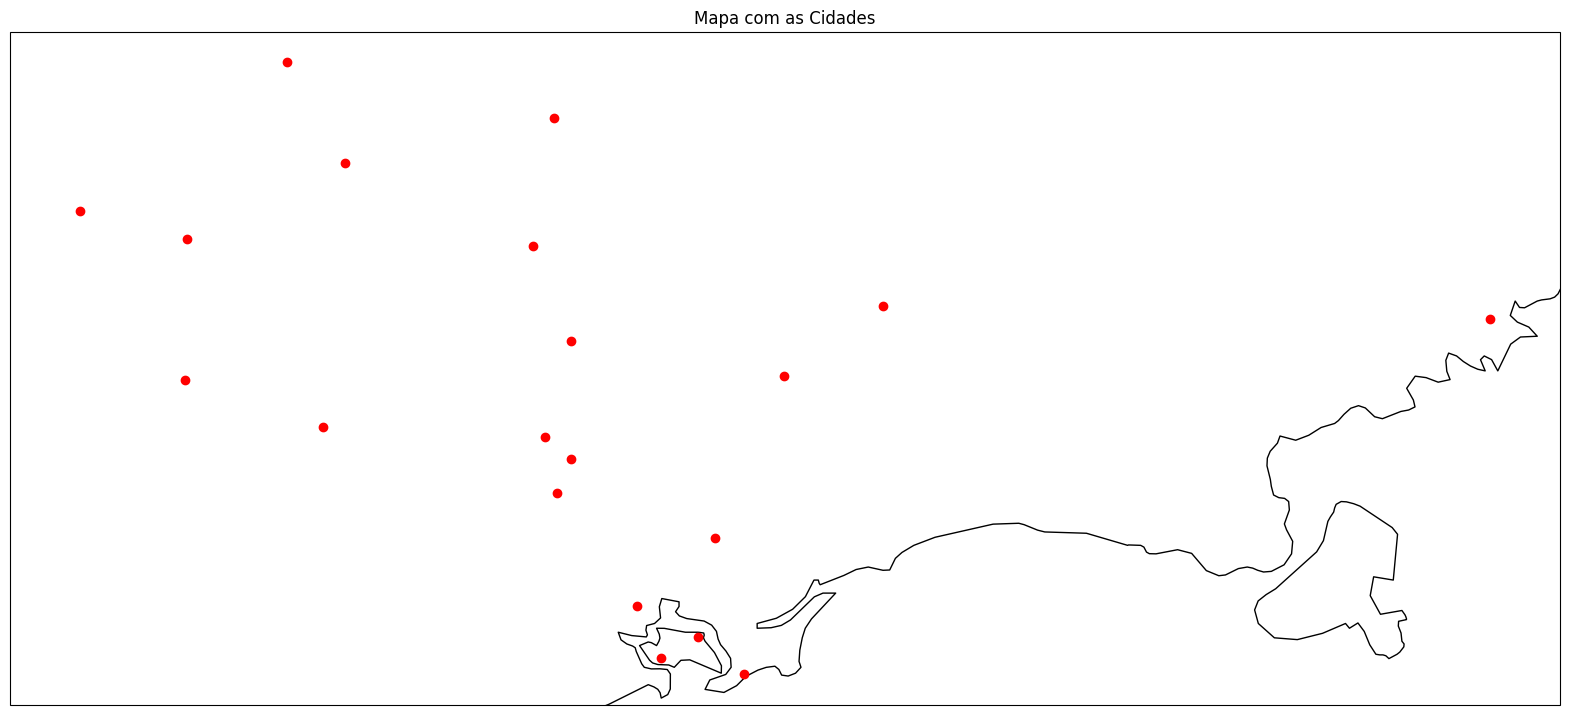

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
for lat, lon in l:
    plt.plot(lon, lat, 'ro', transform=ccrs.PlateCarree())
plt.title('Mapa com as Cidades')
plt.show()

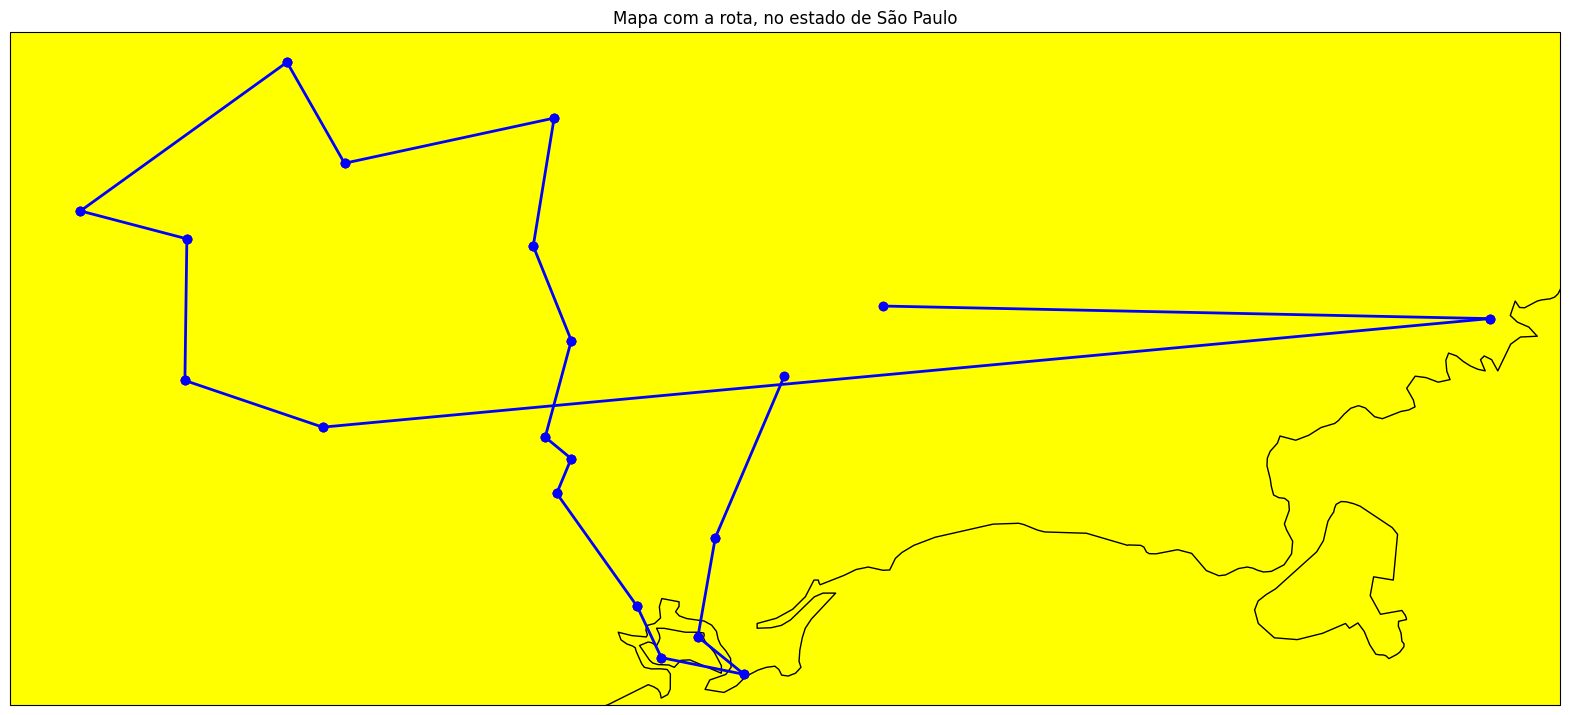

In [ ]:
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
plt.figure(figsize=(20, 10))
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
ax.coastlines(resolution='10m')
for lat, lon in l:
    ax.plot(lon, lat, 'ro', transform=projection)
for i in range(len(l)-1):
    lat1, lon1 = l[i]
    lat2, lon2 = l[i+1]
    ax.plot([lon1, lon2], [lat1, lat2], color='blue', linewidth=2, marker='o', transform=projection)
ax.set_facecolor('yellow')
plt.title('Mapa com a rota, no estado de São Paulo')
plt.show()

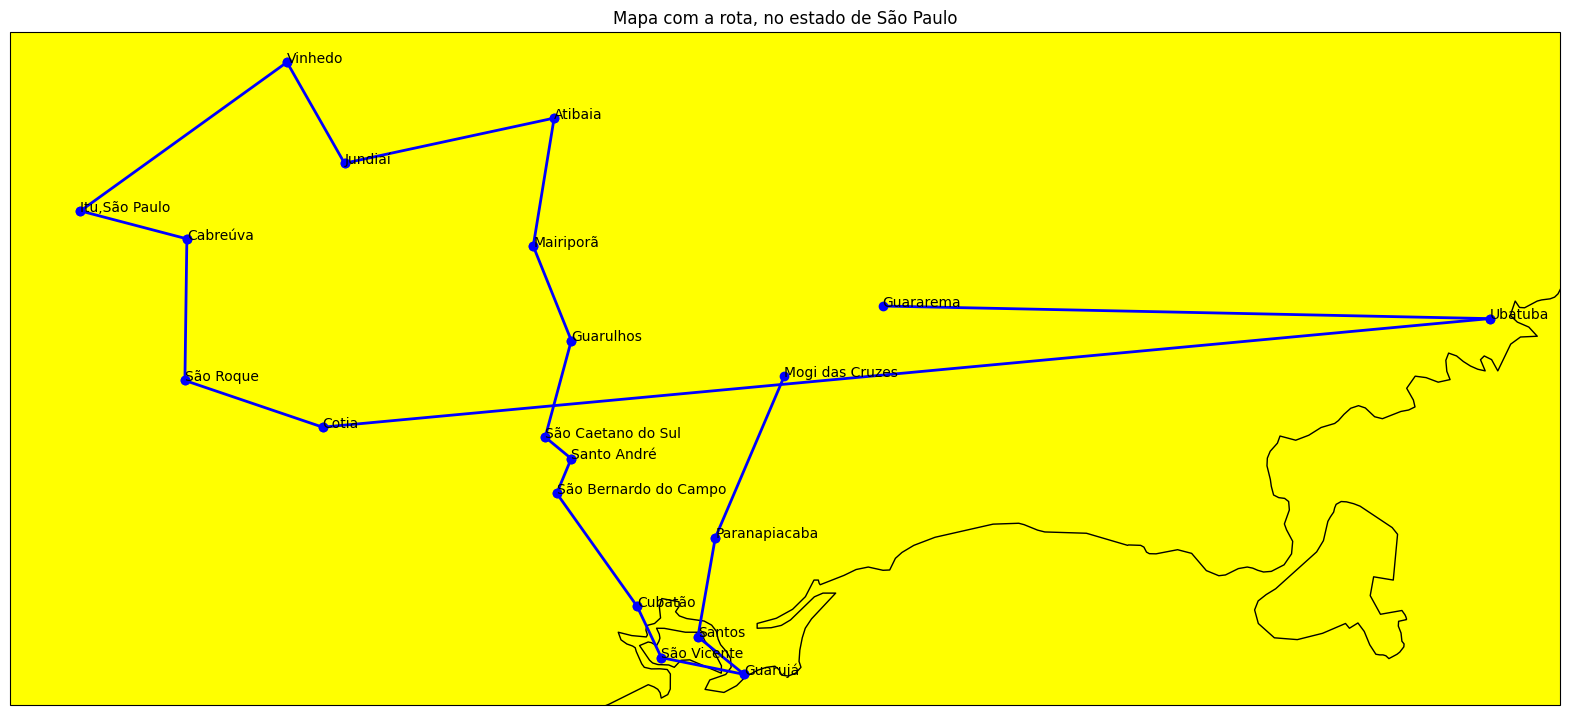

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
plt.figure(figsize=(20, 10))
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
ax.coastlines(resolution='10m')
for city, (lat, lon) in zip(melhor_solucao, l):
    ax.text(lon, lat, city, transform=projection)
for i in range(len(l)-1):
    lat1, lon1 = l[i]
    lat2, lon2 = l[i+1]
    ax.plot([lon1, lon2], [lat1, lat2], color='blue', linewidth=2, marker='o', transform=projection)
ax.set_facecolor('yellow')
plt.title('Mapa com a rota, no estado de São Paulo')
plt.show()

# 2 - 20 pontos de São Paulo com rotas reais

In [ ]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 1.4 MB/s eta 0:00:00


In [ ]:
import osmnx as ox
import networkx as nx

In [ ]:
G = ox.graph_from_place('São Paulo, Brazil', network_type='drive')

In [ ]:
p_zs = (-23.645, -46.696)   # Zona Sul
p_zn = (-23.505, -46.635)   # Zona Norte
p_zl = (-23.557, -46.510)   # Zona Leste
p_zo = (-23.569, -46.723)   # Zona Oeste
p_ib = (-23.587, -46.655)   # Ibirapuera
p_pa = (-23.561, -46.656)   # Avenida Paulista
p_vm = (-23.557, -46.690)   # Vila Madalena
p_co = (-23.627, -46.656)   # Congonhas
p_lz = (-23.536, -46.633)   # Estação da Luz
p_fl = (-23.575, -46.692)   # Avenida Faria Lima
p_pi = (-23.588, -46.658)   # Parque do Ibirapuera
p_vl = (-23.548, -46.717)   # Parque Villa-Lobos
p_ma = (-23.561, -46.656)   # MASP
p_bf = (-23.577, -46.688)   # Brigadeiro Faria Lima
p_mm = (-23.544, -46.629)   # Mercado Municipal
p_tm = (-23.544, -46.638)   # Teatro Municipal
p_ep = (-23.534, -46.635)   # Estação Pinacoteca
p_ml = (-23.527, -46.663)   # Memorial da América Latina
p_in = (-23.588, -46.606)   # Parque da Independência
p_sp = (-23.527, -46.680)
node_zs = ox.distance.nearest_nodes(G, p_zs[1], p_zs[0])
node_zn = ox.distance.nearest_nodes(G, p_zn[1], p_zn[0])
node_zl = ox.distance.nearest_nodes(G, p_zl[1], p_zl[0])
node_zo = ox.distance.nearest_nodes(G, p_zo[1], p_zo[0])
node_ib = ox.distance.nearest_nodes(G, p_ib[1], p_ib[0])
node_pa = ox.distance.nearest_nodes(G, p_pa[1], p_pa[0])
node_vm = ox.distance.nearest_nodes(G, p_vm[1], p_vm[0])
node_co = ox.distance.nearest_nodes(G, p_co[1], p_co[0])
node_lz = ox.distance.nearest_nodes(G, p_lz[1], p_lz[0])
node_fl = ox.distance.nearest_nodes(G, p_fl[1], p_fl[0])
node_pi = ox.distance.nearest_nodes(G, p_pi[1], p_pi[0])
node_vl = ox.distance.nearest_nodes(G, p_vl[1], p_vl[0])
node_ma = ox.distance.nearest_nodes(G, p_ma[1], p_ma[0])
node_bf = ox.distance.nearest_nodes(G, p_bf[1], p_bf[0])
node_mm = ox.distance.nearest_nodes(G, p_mm[1], p_mm[0])
node_tm = ox.distance.nearest_nodes(G, p_tm[1], p_tm[0])
node_ep = ox.distance.nearest_nodes(G, p_ep[1], p_ep[0])
node_ml = ox.distance.nearest_nodes(G, p_ml[1], p_ml[0])
node_in = ox.distance.nearest_nodes(G, p_in[1], p_in[0])
node_sp = ox.distance.nearest_nodes(G, p_sp[1], p_sp[0])

In [ ]:
import networkx as nx
import osmnx as ox

# Supondo que você já tenha carregado o grafo G com os dados de São Paulo

# Definindo os nós correspondentes aos pontos de interesse
node_zs = ox.distance.nearest_nodes(G, p_zs[1], p_zs[0])   # Zona Sul
node_zn = ox.distance.nearest_nodes(G, p_zn[1], p_zn[0])   # Zona Norte
node_zl = ox.distance.nearest_nodes(G, p_zl[1], p_zl[0])   # Zona Leste
node_zo = ox.distance.nearest_nodes(G, p_zo[1], p_zo[0])   # Zona Oeste
node_ib = ox.distance.nearest_nodes(G, p_ib[1], p_ib[0])   # Ibirapuera
node_pa = ox.distance.nearest_nodes(G, p_pa[1], p_pa[0])   # Avenida Paulista
node_vm = ox.distance.nearest_nodes(G, p_vm[1], p_vm[0])   # Vila Madalena
node_co = ox.distance.nearest_nodes(G, p_co[1], p_co[0])   # Congonhas
node_lz = ox.distance.nearest_nodes(G, p_lz[1], p_lz[0])   # Estação da Luz
node_fl = ox.distance.nearest_nodes(G, p_fl[1], p_fl[0])   # Avenida Faria Lima
node_pi = ox.distance.nearest_nodes(G, p_pi[1], p_pi[0])   # Parque do Ibirapuera
node_vl = ox.distance.nearest_nodes(G, p_vl[1], p_vl[0])   # Parque Villa-Lobos
node_ma = ox.distance.nearest_nodes(G, p_ma[1], p_ma[0])   # MASP
# node_bf = ox.distance.nearest_nodes(G, p_bf[1], p_bf[0])   # Brigadeiro Faria Lima
node_mm = ox.distance.nearest_nodes(G, p_mm[1], p_mm[0])   # Mercado Municipal
node_tm = ox.distance.nearest_nodes(G, p_tm[1], p_tm[0])   # Teatro Municipal
node_ep = ox.distance.nearest_nodes(G, p_ep[1], p_ep[0])   # Estação Pinacoteca
node_ml = ox.distance.nearest_nodes(G, p_ml[1], p_ml[0])   # Memorial da América Latina
node_in = ox.distance.nearest_nodes(G, p_in[1], p_in[0])   # Parque da Independência
node_sp = ox.distance.nearest_nodes(G, p_sp[1], p_sp[0])   # Sesc Pompeia

# Calculando os caminhos mais curtos entre os pares de pontos de interesse
path_zs_zn = nx.shortest_path(G, node_zs, node_zn, weight='length')
path_zs_zl = nx.shortest_path(G, node_zs, node_zl, weight='length')
path_zs_zo = nx.shortest_path(G, node_zs, node_zo, weight='length')
path_zs_ib = nx.shortest_path(G, node_zs, node_ib, weight='length')
path_zs_pa = nx.shortest_path(G, node_zs, node_pa, weight='length')
path_zs_vm = nx.shortest_path(G, node_zs, node_vm, weight='length')
path_zs_co = nx.shortest_path(G, node_zs, node_co, weight='length')
path_zs_lz = nx.shortest_path(G, node_zs, node_lz, weight='length')
path_zs_fl = nx.shortest_path(G, node_zs, node_fl, weight='length')
path_zs_pi = nx.shortest_path(G, node_zs, node_pi, weight='length')
path_zs_vl = nx.shortest_path(G, node_zs, node_vl, weight='length')
path_zs_ma = nx.shortest_path(G, node_zs, node_ma, weight='length')
# path_zs_bf = nx.shortest_path(G, node_zs, node_bf, weight='length')  # Removido
path_zs_mm = nx.shortest_path(G, node_zs, node_mm, weight='length')
path_zs_tm = nx.shortest_path(G, node_zs, node_tm, weight='length')
path_zs_ep = nx.shortest_path(G, node_zs, node_ep, weight='length')
path_zs_ml = nx.shortest_path(G, node_zs, node_ml, weight='length')
path_zs_in = nx.shortest_path(G, node_zs, node_in, weight='length')
path_zs_sp = nx.shortest_path(G, node_zs, node_sp, weight='length')

# Exemplo de uso:
print("Caminho mais curto entre Zona Sul e Zona Norte:", path_zs_zn)
print("Caminho mais curto entre Zona Sul e Zona Leste:", path_zs_zl)
print("Caminho mais curto entre Zona Sul e Zona Oeste:", path_zs_zo)
# E assim por diante para todos os pares de pontos de interesse definidos


Caminho mais curto entre Zona Sul e Zona Norte: [305664326, 8507937463, 8507937459, 1337866363, 305664293, 301868190, 254382795, 301868176, 301868171, 3359512151, 301190083, 301868089, 301868104, 28637322, 3312393279, 301868080, 28637615, 1379439911, 3354417142, 3354417156, 664063906, 301868037, 299309150, 299610844, 664063916, 1937130505, 7306603158, 7796981393, 28637859, 4037081571, 301867981, 4040697098, 11060052936, 28637975, 299774497, 7302051482, 28638000, 28636604, 304693515, 304693510, 304693504, 1389167638, 304693497, 28636797, 2577302635, 304693609, 304693561, 304693557, 1550389901, 1550389899, 303987563, 303987560, 303987347, 303987724, 303987700, 1389167490, 303987219, 5046267597, 303987821, 303987260, 28636359, 303987295, 303987352, 5046262359, 265577204, 2577302530, 1389167308, 1389167293, 1389167280, 142811324, 142811323, 4484877102, 1942703721, 142811321, 142811320, 303788554, 1942703864, 303788688, 303788470, 303788550, 303788683, 1942703818, 1942703850, 3315170392, 33

In [ ]:
import folium
center_lat = -23.55
center_lon = -46.64
sp_map = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Adicionando os pontos de interesse ao mapa
folium.Marker(p_zs, popup='Zona Sul').add_to(sp_map)
folium.Marker(p_zn, popup='Zona Norte').add_to(sp_map)
folium.Marker(p_zl, popup='Zona Leste').add_to(sp_map)
folium.Marker(p_zo, popup='Zona Oeste').add_to(sp_map)
folium.Marker(p_ib, popup='Ibirapuera').add_to(sp_map)
folium.Marker(p_pa, popup='Avenida Paulista').add_to(sp_map)
folium.Marker(p_vm, popup='Vila Madalena').add_to(sp_map)
folium.Marker(p_co, popup='Congonhas').add_to(sp_map)
folium.Marker(p_lz, popup='Estação da Luz').add_to(sp_map)
folium.Marker(p_fl, popup='Avenida Faria Lima').add_to(sp_map)
folium.Marker(p_pi, popup='Parque do Ibirapuera').add_to(sp_map)
folium.Marker(p_vl, popup='Parque Villa-Lobos').add_to(sp_map)
folium.Marker(p_ma, popup='MASP').add_to(sp_map)
folium.Marker(p_mm, popup='Mercado Municipal').add_to(sp_map)
folium.Marker(p_tm, popup='Teatro Municipal').add_to(sp_map)
folium.Marker(p_ep, popup='Estação Pinacoteca').add_to(sp_map)
folium.Marker(p_ml, popup='Memorial da América Latina').add_to(sp_map)
folium.Marker(p_in, popup='Parque da Independência').add_to(sp_map)
folium.Marker(p_sp, popup='Sesc Pompeia').add_to(sp_map)

# Função para adicionar uma linha ao mapa
def add_path_to_map(path, color):
    folium.PolyLine(locations=[(G.nodes[node]['y'], G.nodes[node]['x']) for node in path],
                    color=color,
                    weight=5,
                    opacity=0.6).add_to(sp_map)

# Adicionando as rotas ao mapa
add_path_to_map(path_zs_zn, 'blue')
add_path_to_map(path_zs_zl, 'red')
add_path_to_map(path_zs_zo, 'green')
add_path_to_map(path_zs_ib, 'purple')
add_path_to_map(path_zs_pa, 'orange')
add_path_to_map(path_zs_vm, 'yellow')
add_path_to_map(path_zs_co, 'black')
add_path_to_map(path_zs_lz, 'pink')
add_path_to_map(path_zs_fl, 'brown')
add_path_to_map(path_zs_pi, 'gray')
add_path_to_map(path_zs_vl, 'cyan')
add_path_to_map(path_zs_ma, 'lime')
add_path_to_map(path_zs_mm, 'magenta')
add_path_to_map(path_zs_tm, 'indigo')
add_path_to_map(path_zs_ep, 'darkblue')
add_path_to_map(path_zs_ml, 'darkred')
add_path_to_map(path_zs_in, 'darkgreen')
add_path_to_map(path_zs_sp, 'gold')

# Exibindo o mapa
sp_map




In [ ]:
proximities = {
    'Campinas': (-22.9071, -47.0632),
    'Santos': (-23.9548, -46.3322),
    'São José dos Campos': (-23.2237, -45.9009),
    'Sorocaba': (-23.5015, -47.4523),
    'Jundiaí': (-23.1857, -46.8978),
    'Guarulhos': (-23.4545, -46.5332),
    'Barueri': (-23.5052, -46.8797),
    'Osasco': (-23.5329, -46.7926),
    'Itu': (-23.264, -47.2996),
    'Indaiatuba': (-23.0905, -47.2116)
}

# Criando um mapa centrado em São Paulo
center_lat = -23.55
center_lon = -46.64
sp_map = folium.Map(location=[center_lat, center_lon], zoom_start=9)

# Adicionando os nós (cidades) ao mapa como marcadores
for city, coord in proximities.items():
    folium.Marker(location=coord, popup=city).add_to(sp_map)

# Adicionando as arestas (ruas) do grafo ao mapa como linhas
for u, v, data in G.edges(data=True):
    u_loc = G.nodes[u]['y'], G.nodes[u]['x']
    v_loc = G.nodes[v]['y'], G.nodes[v]['x']
    folium.PolyLine(locations=[u_loc, v_loc], color='blue').add_to(sp_map)

# Exibindo o mapa
sp_map


KeyError: 'y'

# 3 - Todos municipios de sp

## TSP - 2opt 645 municipios de SP

In [ ]:
import random
import time
from folium import Map, PolyLine, LayerControl, Marker, Popup
from py2opt.solver import Solver
import geopy.distance as geodist
import numpy as np
import pandas as pd
import geopandas as gpd
from geopy.distance import geodesic

class RouteFinder:
    def __init__(self, dist_matrix, city_coords, city_names, num_iterations=5, enable_writer=False, method='py2opt', return_to_start=False, is_verbose=True):
        self.dist_matrix = dist_matrix
        self.num_iterations = num_iterations
        self.return_to_start = return_to_start
        self.enable_writer = enable_writer
        self.city_names = city_names
        self.is_verbose = is_verbose
        self.distances_per_iter = []  # List to store distances for plotting
        self.city_coords = city_coords  # City coordinates (latitude, longitude)
        self.routes_per_iter = []  # List to store routes from each iteration

    def solve(self):
        start_time_ms = round(time.time() * 1000)
        elapsed_time_ms = 0
        current_iter = 0
        optimal_distance = float('inf')
        optimal_route = []

        while current_iter < self.num_iterations:
            total_cities = len(self.dist_matrix)
            if self.is_verbose:
                print(f"{elapsed_time_ms} msec")
            random_route = [0] + random.sample(range(1, total_cities), total_cities - 1) + [0]
            solver = Solver(self.dist_matrix, random_route)
            improved_route, improved_distance, route_distances = solver.two_opt()

            if improved_distance < optimal_distance:
                optimal_distance = improved_distance
                optimal_route = improved_route

            self.routes_per_iter.append(improved_route.copy())  # Store route for each iteration
            self.distances_per_iter.append(optimal_distance)
            elapsed_time_ms = round(time.time() * 1000) - start_time_ms
            current_iter += 1

        if self.enable_writer:
            self.writer(optimal_route, optimal_distance, self.city_names)

        if self.city_names:
            optimal_route = [self.city_names[i] for i in optimal_route]
        return optimal_distance, optimal_route

    @staticmethod
    def writer(optimal_route, optimal_distance, city_names):
        with open("results.txt", "w+") as f:
            for i in optimal_route:
                f.write(f"{city_names[i]}\n")
            f.write(str(optimal_distance))

    def create_initial_map(self):
        start_lat = self.city_coords[0][0]
        start_lng = self.city_coords[0][1]
        return Map(location=[start_lat, start_lng], zoom_start=8)

    def plot_best_route(self):
        map_obj = self.create_initial_map()

        final_route = self.routes_per_iter[-1]
        final_polyline = PolyLine(
            locations=[[self.city_coords[j][0], self.city_coords[j][1]] for j in final_route],
            color='red',
            weight=3,
            opacity=0.8,
            tooltip=f'Best Route: Distance {self.distances_per_iter[-1]:.2f} km'
        )
        final_polyline.add_to(map_obj)

        for name, coordinates in zip(self.city_names, self.city_coords):
            Marker(
                location=(coordinates[0], coordinates[1]),
                popup=Popup(name, parse_html=True)
            ).add_to(map_obj)

        LayerControl().add_to(map_obj)
        return map_obj

# Load GeoDataFrame
gdf = gpd.read_file('/content/geojs-35-mun.json')
gdf['centroid'] = gdf['geometry'].centroid

# Extract city names and coordinates
city_names = gdf['name'].to_list()
city_coords = [(point.y, point.x) for point in gdf['centroid']]

# Create distance matrix
origem = []
destino = []
distancias = []
for i, nome1 in enumerate(city_names):
    p1 = (gdf['centroid'][i].y, gdf['centroid'][i].x)
    for j, nome2 in enumerate(city_names):
        p2 = (gdf['centroid'][j].y, gdf['centroid'][j].x)
        origem.append(nome1)
        destino.append(nome2)
        distancias.append(geodesic(p1, p2).km)

df = pd.DataFrame({'origem': origem, 'destino': destino, 'distancia': distancias})

# Pivot the DataFrame to get the distance matrix
dist_matrix = df.pivot_table(index='origem', columns='destino', values='distancia').to_numpy()

# Number of iterations
num_iterations = 5000

# Create an instance of RouteFinder
route_finder = RouteFinder(dist_matrix, city_coords, city_names, num_iterations)

# Solve TSP
optimal_distance, optimal_route = route_finder.solve()

# Plot the best route on a map
map_obj = route_finder.plot_best_route()

print(optimal_distance)
print(optimal_route)


<ipython-input-9-ec9975f9d2a3>:90: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf['geometry'].centroid


A saída de streaming foi truncada nas últimas 5000 linhas.
6569 msec
9729 msec
12885 msec
17088 msec
19918 msec
22762 msec
25826 msec
29862 msec
32622 msec
35774 msec
38597 msec
42835 msec
45682 msec
48473 msec
51665 msec
55896 msec
59285 msec
62989 msec
66703 msec
70126 msec
72936 msec
76190 msec
79776 msec
83198 msec
86062 msec
88868 msec
92097 msec
95819 msec
98627 msec
101752 msec
104797 msec
108736 msec
111534 msec
114725 msec
118304 msec
122399 msec
124826 msec
127193 msec
129964 msec
134229 msec
137028 msec
139774 msec
142497 msec
146699 msec
149567 msec
152345 msec
155118 msec
158734 msec
162137 msec
164936 msec
167687 msec
170785 msec
174701 msec
177469 msec
180609 msec
183420 msec
187522 msec
190311 msec
193164 msec
195933 msec
200520 msec
203662 msec
206793 msec
210275 msec
215784 msec
219241 msec
222413 msec
226496 msec
229989 msec
233202 msec
235951 msec
238802 msec
243108 msec
245972 msec
248790 msec
251817 msec
256217 msec
259012 msec
261780 msec
264578 msec
269310 msec


15519608 msec
11685.65


In [ ]:
map_obj

In [ ]:
import random
import time
from folium import Map, PolyLine, LayerControl, Marker, Popup
from py2opt.solver import Solver
import geopy.distance as geodist
import numpy as np
import pandas as pd
import geopandas as gpd
from geopy.distance import geodesic


In [ ]:
class RouteFinder:
    def __init__(self, dist_matrix, city_coords, city_names, num_iterations=5, enable_writer=False, method='py2opt', return_to_start=False, is_verbose=True):
        self.dist_matrix = dist_matrix
        self.num_iterations = num_iterations
        self.return_to_start = return_to_start
        self.enable_writer = enable_writer
        self.city_names = city_names
        self.is_verbose = is_verbose
        self.distances_per_iter = []  # List to store distances for plotting
        self.city_coords = city_coords  # City coordinates (latitude, longitude)
        self.routes_per_iter = []  # List to store routes from each iteration

    def solve(self):
        start_time_ms = round(time.time() * 1000)
        elapsed_time_ms = 0
        optimal_distance = float('inf')
        optimal_route = []

        # Start with an initial subset of cities
        current_cities = [0]  # Start with the first city

        while len(current_cities) < len(self.city_coords):
            #if self.is_verbose:
             #   print(f"{elapsed_time_ms} msec")

            # Create a distance matrix for the current subset of cities
            current_dist_matrix = self.dist_matrix[np.ix_(current_cities, current_cities)]

            # Generate a random route for the current subset
            total_cities = len(current_dist_matrix)
            random_route = list(range(total_cities))
            random.shuffle(random_route)
            random_route = [0] + random_route + [0]

            solver = Solver(current_dist_matrix, random_route)
            improved_route, improved_distance, route_distances = solver.two_opt()

            if improved_distance < optimal_distance:
                optimal_distance = improved_distance
                optimal_route = [current_cities[i] for i in improved_route]

            self.routes_per_iter.append(optimal_route.copy())  # Store route for each iteration
            self.distances_per_iter.append(optimal_distance)

            # Add the next city if it exists
            if len(current_cities) < len(self.city_coords):
                current_cities.append(len(current_cities))

            elapsed_time_ms = round(time.time() * 1000) - start_time_ms

        if self.enable_writer:
            self.writer(optimal_route, optimal_distance, self.city_names)

        if self.city_names:
            optimal_route = [self.city_names[i] for i in optimal_route]
        return optimal_distance, optimal_route

    @staticmethod
    def writer(optimal_route, optimal_distance, city_names):
        with open("results.txt", "w+") as f:
            for i in optimal_route:
                f.write(f"{city_names[i]}\n")
            f.write(str(optimal_distance))

    def create_initial_map(self):
        start_lat = self.city_coords[0][0]
        start_lng = self.city_coords[0][1]
        return Map(location=[start_lat, start_lng], zoom_start=8)

    def plot_best_route(self):
        map_obj = self.create_initial_map()

        final_route = self.routes_per_iter[-1]
        final_polyline = PolyLine(
            locations=[[self.city_coords[j][0], self.city_coords[j][1]] for j in final_route],
            color='red',
            weight=3,
            opacity=0.8,
            tooltip=f'Best Route: Distance {self.distances_per_iter[-1]:.2f} km'
        )
        final_polyline.add_to(map_obj)

        for name, coordinates in zip(self.city_names, self.city_coords):
            Marker(
                location=(coordinates[0], coordinates[1]),
                popup=Popup(name, parse_html=True)
            ).add_to(map_obj)

        LayerControl().add_to(map_obj)
        return map_obj

## TSP 645


In [ ]:
import geopandas as gpd

# Carregar o GeoDataFrame a partir do arquivo GeoJSON
gdf = gpd.read_file('/content/geojs-35-mun.json')

# Calcular o centróide de cada geometria
gdf['centroid'] = gdf['geometry'].centroid

# Extrair nomes das cidades e coordenadas dos centroides
city_names = gdf['name'].to_list()
city_coords = [(point.y, point.x) for point in gdf['centroid']]

# Criar dicionário de coordenadas das cidades
city_coordinates_dict = {city_names[i]: city_coords[i] for i in range(len(city_names))}




{'Adamantina': (-21.576304270889878, -51.05616219188306), 'Adolfo': (-21.288078046562557, -49.65281480574286), 'Aguaí': (-22.049604954753647, -47.039711091497935), 'Águas da Prata': (-21.91375720082714, -46.691309551184716), 'Águas de Lindóia': (-22.47405169387128, -46.60304930368094), 'Águas de Santa Bárbara': (-22.85850793848385, -49.26039315603515), 'Águas de São Pedro': (-22.599020058258866, -47.87598238958155), 'Agudos': (-22.571081513916116, -49.10790475015966), 'Alambari': (-23.54861169263054, -47.86833591006229), 'Alfredo Marcondes': (-21.934925923514967, -51.39558658380303), 'Altair': (-20.532974220890562, -49.093705342599016), 'Altinópolis': (-21.017674541184302, -47.38596859443083), 'Alto Alegre': (-21.612192045208776, -50.19156354534441), 'Alumínio': (-23.532520562957462, -47.280995340869026), 'Álvares Florence': (-20.289139334148434, -49.919608005205475), 'Álvares Machado': (-22.131588783623133, -51.514720503213084), 'Álvaro de Carvalho': (-22.086285781755237, -49.73331290

<ipython-input-2-0fea350060f3>:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf['geometry'].centroid


In [ ]:
city_coordinates_dict

{'Adamantina': (-21.576304270889878, -51.05616219188306),
 'Adolfo': (-21.288078046562557, -49.65281480574286),
 'Aguaí': (-22.049604954753647, -47.039711091497935),
 'Águas da Prata': (-21.91375720082714, -46.691309551184716),
 'Águas de Lindóia': (-22.47405169387128, -46.60304930368094),
 'Águas de Santa Bárbara': (-22.85850793848385, -49.26039315603515),
 'Águas de São Pedro': (-22.599020058258866, -47.87598238958155),
 'Agudos': (-22.571081513916116, -49.10790475015966),
 'Alambari': (-23.54861169263054, -47.86833591006229),
 'Alfredo Marcondes': (-21.934925923514967, -51.39558658380303),
 'Altair': (-20.532974220890562, -49.093705342599016),
 'Altinópolis': (-21.017674541184302, -47.38596859443083),
 'Alto Alegre': (-21.612192045208776, -50.19156354534441),
 'Alumínio': (-23.532520562957462, -47.280995340869026),
 'Álvares Florence': (-20.289139334148434, -49.919608005205475),
 'Álvares Machado': (-22.131588783623133, -51.514720503213084),
 'Álvaro de Carvalho': (-22.0862857817552

In [ ]:
import random
import time
from folium import Map, PolyLine, LayerControl, Marker, Popup
from py2opt.solver import Solver
import geopy.distance as geodist
import numpy as np
import pandas as pd
import geopandas as gpd
from geopy.distance import geodesic
from joblib import Parallel, delayed

class RouteFinder:
    def __init__(self, dist_matrix, city_coords, city_names, num_iterations=5, enable_writer=False, method='py2opt', return_to_start=False, is_verbose=True):
        self.dist_matrix = dist_matrix
        self.num_iterations = num_iterations
        self.return_to_start = return_to_start
        self.enable_writer = enable_writer
        self.city_names = city_names
        self.is_verbose = is_verbose
        self.distances_per_iter = []  # List to store distances for plotting
        self.city_coords = city_coords  # City coordinates (latitude, longitude)
        self.routes_per_iter = []  # List to store routes from each iteration

    def solve(self):
        start_time_ms = round(time.time() * 1000)
        elapsed_time_ms = 0
        current_iter = 0
        optimal_distance = float('inf')
        optimal_route = []

        while current_iter < self.num_iterations:
            total_cities = len(self.dist_matrix)
            if self.is_verbose:
                print(f"{elapsed_time_ms} msec")
            random_route = [0] + random.sample(range(1, total_cities), total_cities - 1)
            if self.return_to_start:
                random_route.append(0)
            solver = Solver(self.dist_matrix, random_route)
            improved_route, improved_distance, route_distances = solver.two_opt()

            if improved_distance < optimal_distance:
                optimal_distance = improved_distance
                optimal_route = improved_route

            self.routes_per_iter.append(improved_route.copy())  # Store route for each iteration
            self.distances_per_iter.append(optimal_distance)
            elapsed_time_ms = round(time.time() * 1000) - start_time_ms
            current_iter += 1

        optimal_route = self.correct_crossings(optimal_route, self.city_coords)

        if self.enable_writer:
            self.writer(optimal_route, optimal_distance, self.city_names)

        if self.city_names:
            optimal_route = [self.city_names[i] for i in optimal_route]
        return optimal_distance, optimal_route

    @staticmethod
    def writer(optimal_route, optimal_distance, city_names):
        with open("results.txt", "w+") as f:
            for i in optimal_route:
                f.write(f"{city_names[i]}\n")
            f.write(str(optimal_distance))

    @staticmethod
    def lines_intersect(p1, p2, q1, q2):
        def ccw(a, b, c):
            return (c[1] - a[1]) * (b[0] - a[0]) > (b[1] - a[1]) * (c[0] - a[0])
        return ccw(p1, q1, q2) != ccw(p2, q1, q2) and ccw(p1, p2, q1) != ccw(p1, p2, q2)

    @staticmethod
    def correct_crossings(path, coords):
        improved = True
        while improved:
            improved = False
            for i in range(len(path) - 1):
                for j in range(i + 2, len(path) - 1):
                    if RouteFinder.lines_intersect(coords[path[i]], coords[path[i + 1]], coords[path[j]], coords[path[j + 1]]):
                        # Swap the segments to remove the intersection
                        path[i + 1:j + 1] = reversed(path[i + 1:j + 1])
                        improved = True
        return path

    def create_initial_map(self):
        start_lat = self.city_coords[0][0]
        start_lng = self.city_coords[0][1]
        return Map(location=[start_lat, start_lng], zoom_start=8)

    def plot_best_route(self):
        map_obj = self.create_initial_map()

        final_route = self.routes_per_iter[-1]
        final_polyline = PolyLine(
            locations=[[self.city_coords[j][0], self.city_coords[j][1]] for j in final_route],
            color='red',
            weight=3,
            opacity=0.8,
            tooltip=f'Best Route: Distance {self.distances_per_iter[-1]:.2f} km'
        )
        final_polyline.add_to(map_obj)

        for name, coordinates in zip(self.city_names, self.city_coords):
            Marker(
                location=(coordinates[0], coordinates[1]),
                popup=Popup(name, parse_html=True)
            ).add_to(map_obj)

        LayerControl().add_to(map_obj)
        return map_obj

# Load GeoDataFrame
gdf = gpd.read_file('/content/geojs-35-mun.json')
gdf['centroid'] = gdf['geometry'].centroid

# Extract city names and coordinates
city_names = gdf['name'].to_list()
city_coords = [(point.y, point.x) for point in gdf['centroid']]

# Create distance matrix using parallel computation
def calculate_distances(city_names, gdf):
    def geodesic_distance(i, j):
        p1 = (gdf['centroid'][i].y, gdf['centroid'][i].x)
        p2 = (gdf['centroid'][j].y, gdf['centroid'][j].x)
        return geodesic(p1, p2).km

    dist_matrix = Parallel(n_jobs=-1)(delayed(geodesic_distance)(i, j) for i in range(len(city_names)) for j in range(len(city_names)))
    return np.array(dist_matrix).reshape(len(city_names), len(city_names))

dist_matrix = calculate_distances(city_names, gdf)

# Number of iterations
num_iterations = 5000

# Create an instance of RouteFinder
route_finder = RouteFinder(dist_matrix, city_coords, city_names, num_iterations, return_to_start=True)

# Solve TSP
optimal_distance, optimal_route = route_finder.solve()

# Plot the best route on a map
map_obj = route_finder.plot_best_route()

print(optimal_distance)
print(optimal_route)


In [ ]:
import random
import time
from folium import Map, PolyLine, LayerControl, Marker, Popup
from py2opt.solver import Solver
import geopy.distance as geodist
import numpy as np
import pandas as pd
import geopandas as gpd
from geopy.distance import geodesic

class RouteFinder:
    def __init__(self, dist_matrix, city_coords, city_names, num_iterations=5, enable_writer=False, method='py2opt', return_to_start=False, is_verbose=True):
        self.dist_matrix = dist_matrix
        self.num_iterations = num_iterations
        self.return_to_start = return_to_start
        self.enable_writer = enable_writer
        self.city_names = city_names
        self.is_verbose = is_verbose
        self.distances_per_iter = []  # List to store distances for plotting
        self.city_coords = city_coords  # City coordinates (latitude, longitude)
        self.routes_per_iter = []  # List to store routes from each iteration

    def solve(self):
        start_time_ms = round(time.time() * 1000)
        elapsed_time_ms = 0
        current_iter = 0
        optimal_distance = float('inf')
        optimal_route = []

        while current_iter < self.num_iterations:
            total_cities = len(self.dist_matrix)
            if self.is_verbose:
                print(f"{elapsed_time_ms} msec")
            random_route = [0] + random.sample(range(1, total_cities), total_cities - 1)
            if self.return_to_start:
                random_route.append(0)
            solver = Solver(self.dist_matrix, random_route)
            improved_route, improved_distance, route_distances = solver.two_opt()

            if improved_distance < optimal_distance:
                optimal_distance = improved_distance
                optimal_route = improved_route

            self.routes_per_iter.append(improved_route.copy())  # Store route for each iteration
            self.distances_per_iter.append(optimal_distance)
            elapsed_time_ms = round(time.time() * 1000) - start_time_ms
            current_iter += 1

        optimal_route = self.correct_crossings(optimal_route, self.city_coords)

        if self.enable_writer:
            self.writer(optimal_route, optimal_distance, self.city_names)

        if self.city_names:
            optimal_route = [self.city_names[i] for i in optimal_route]
        return optimal_distance, optimal_route

    @staticmethod
    def writer(optimal_route, optimal_distance, city_names):
        with open("results.txt", "w+") as f:
            for i in optimal_route:
                f.write(f"{city_names[i]}\n")
            f.write(str(optimal_distance))

    @staticmethod
    def lines_intersect(p1, p2, q1, q2):
        def ccw(a, b, c):
            return (c[1] - a[1]) * (b[0] - a[0]) > (b[1] - a[1]) * (c[0] - a[0])
        return ccw(p1, q1, q2) != ccw(p2, q1, q2) and ccw(p1, p2, q1) != ccw(p1, p2, q2)

    @staticmethod
    def correct_crossings(path, coords):
        improved = True
        while improved:
            improved = False
            for i in range(len(path) - 1):
                for j in range(i + 2, len(path) - 1):
                    if RouteFinder.lines_intersect(coords[path[i]], coords[path[i + 1]], coords[path[j]], coords[path[j + 1]]):
                        # Swap the segments to remove the intersection
                        path[i + 1:j + 1] = reversed(path[i + 1:j + 1])
                        improved = True
        return path

    def create_initial_map(self):
        start_lat = self.city_coords[0][0]
        start_lng = self.city_coords[0][1]
        return Map(location=[start_lat, start_lng], zoom_start=8)

    def plot_best_route(self):
        map_obj = self.create_initial_map()

        final_route = self.routes_per_iter[-1]
        final_polyline = PolyLine(
            locations=[[self.city_coords[j][0], self.city_coords[j][1]] for j in final_route],
            color='red',
            weight=3,
            opacity=0.8,
            tooltip=f'Best Route: Distance {self.distances_per_iter[-1]:.2f} km'
        )
        final_polyline.add_to(map_obj)

        for name, coordinates in zip(self.city_names, self.city_coords):
            Marker(
                location=(coordinates[0], coordinates[1]),
                popup=Popup(name, parse_html=True)
            ).add_to(map_obj)

        LayerControl().add_to(map_obj)
        return map_obj

# Load GeoDataFrame
gdf = gpd.read_file('/content/geojs-35-mun.json')
gdf['centroid'] = gdf['geometry'].centroid

# Extract city names and coordinates
city_names = gdf['name'].to_list()
city_coords = [(point.y, point.x) for point in gdf['centroid']]

# Create distance matrix
origem = []
destino = []
distancias = []
for i, nome1 in enumerate(city_names):
    p1 = (gdf['centroid'][i].y, gdf['centroid'][i].x)
    for j, nome2 in enumerate(city_names):
        p2 = (gdf['centroid'][j].y, gdf['centroid'][j].x)
        origem.append(nome1)
        destino.append(nome2)
        distancias.append(geodesic(p1, p2).km)

df = pd.DataFrame({'origem': origem, 'destino': destino, 'distancia': distancias})

# Pivot the DataFrame to get the distance matrix
dist_matrix = df.pivot_table(index='origem', columns='destino', values='distancia').to_numpy()

# Number of iterations
num_iterations = 5000

# Create an instance of RouteFinder
route_finder = RouteFinder(dist_matrix, city_coords, city_names, num_iterations, return_to_start=True)

# Solve TSP
optimal_distance, optimal_route = route_finder.solve()

# Plot the best route on a map
map_obj = route_finder.plot_best_route()

print(optimal_distance)
print(optimal_route)


<ipython-input-7-d8519759bde8>:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf['geometry'].centroid


A saída de streaming foi truncada nas últimas 5000 linhas.
6645 msec
9209 msec
11865 msec
14460 msec
18193 msec
21025 msec
23651 msec
26268 msec
28954 msec
32855 msec
35534 msec
38145 msec
40825 msec
44771 msec
47717 msec
50717 msec
52901 msec
56869 msec
59672 msec
62306 msec
64803 msec
67388 msec
71324 msec
74212 msec
76718 msec
79661 msec
83588 msec
86396 msec
89484 msec
93180 msec
96804 msec
99660 msec
102246 msec
104884 msec
108114 msec
111501 msec
114115 msec
117128 msec
120352 msec
123798 msec
126472 msec
129749 msec
132697 msec
136543 msec
139174 msec
141818 msec
144502 msec
150278 msec
152863 msec
155409 msec
157974 msec
161054 msec
164817 msec
167391 msec
170370 msec
173703 msec
177332 msec
180320 msec
182931 msec
185992 msec
189878 msec
192467 msec
195014 msec
197599 msec
201483 msec
204171 msec
206707 msec
209303 msec
212028 msec
215865 msec
218494 msec
221102 msec
224087 msec
228083 msec
230692 msec
233662 msec
236314 msec
240066 msec
242861 msec
245492 msec
248096 msec
250

In [ ]:
https://github.com/LeonardoKoide/PucTSP2024.1

In [ ]:
import geopandas as gpd
import folium
import numpy as np
from geopy.distance import great_circle
from itertools import combinations
from joblib import Parallel, delayed
import time
import random2
from py2opt.solver import Solver

# Classe RouteFinder importada do seu código
class RouteFinder:
    def __init__(self, distance_matrix, cities_names, iterations=5, writer_flag=False, method='py2opt', return_to_begin=False, verbose=True):
        self.distance_matrix = distance_matrix
        self.iterations = iterations
        self.return_to_begin = return_to_begin
        self.writer_flag = writer_flag
        self.cities_names = cities_names
        self.verbose = verbose

    def solve(self):
        start_time = round(time.time() * 1000)
        elapsed_time = 0
        iteration = 0
        best_distance = 0
        best_route = []
        best_distances = []

        while iteration < self.iterations:
            num_cities = len(self.distance_matrix)
            if self.verbose:
                print(round(elapsed_time), 'msec')
            initial_route = [0] + random2.sample(range(1, num_cities), num_cities - 1)
            if self.return_to_begin:
                initial_route.append(0)
            tsp = Solver(self.distance_matrix, initial_route)
            new_route, new_distance, distances = tsp.two_opt()

            if iteration == 0:
                best_distance = new_distance
                best_route = new_route
            else:
                pass

            if new_distance < best_distance:
                best_distance = new_distance
                best_route = new_route
                best_distances = distances

            elapsed_time = round(time.time() * 1000) - start_time
            iteration += 1

        if self.writer_flag:
            self.writer(best_route, best_distance, self.cities_names)

        if self.cities_names:
            best_route = [self.cities_names[i] for i in best_route]
            return best_distance, best_route
        else:
            return best_distance, best_route

    @staticmethod
    def writer(best_route, best_distance, cities_names):
        with open("../results.txt", "w+") as f:
            for i in best_route:
                f.write(cities_names[i])
                f.write("\n")
                print(cities_names[i])
            f.write(str(best_distance))

# Carregando o arquivo JSON com os municípios de São Paulo
G = gpd.read_file('/content/geojs-35-mun.json')

# Função para obter as coordenadas do centróide
def get_centroid_coords(geometry):
    centroid = geometry.centroid
    return centroid.y, centroid.x  # Retorna lat, lon

# Função para verificar se duas linhas se cruzam
def lines_intersect(p1, p2, q1, q2):
    def ccw(a, b, c):
        return (c[1] - a[1]) * (b[0] - a[0]) > (b[1] - a[1]) * (c[0] - a[0])
    return ccw(p1, q1, q2) != ccw(p2, q1, q2) and ccw(p1, p2, q1) != ccw(p1, p2, q2)

# Função para corrigir cruzamentos no caminho
def correct_crossings(path, coords):
    improved = True
    while improved:
        improved = False
        for i in range(len(path) - 1):
            for j in range(i + 2, len(path) - 1):
                if lines_intersect(coords[path[i]], coords[path[i + 1]], coords[path[j]], coords[path[j + 1]]):
                    # Swap the segments to remove the intersection
                    path[i + 1:j + 1] = reversed(path[i + 1:j + 1])
                    improved = True
    return path

# Extraindo os centróides de todos os municípios
coord = [get_centroid_coords(geom) for geom in G.geometry]

# Limitar a quantidade de dados para um teste inicial
coord = coord[:645]

# Criação da matriz de distâncias
print("Calculando a matriz de distâncias...")
start_time = time.time()
num_cities = len(coord)
distance_matrix = np.zeros((num_cities, num_cities))

def calc_distance(i, j):
    return great_circle(coord[i], coord[j]).kilometers

results = Parallel(n_jobs=-1)(delayed(calc_distance)(i, j) for i, j in combinations(range(num_cities), 2))

for (i, j), dist in zip(combinations(range(num_cities), 2), results):
    distance_matrix[i, j] = dist
    distance_matrix[j, i] = dist
print(f"Matriz de distâncias calculada em {time.time() - start_time:.2f} segundos.")

# Nomes das cidades para referência
cities_names = [G.iloc[i]['name'] for i in range(len(coord))]

# Inicializando e resolvendo o problema com RouteFinder
route_finder = RouteFinder(distance_matrix, cities_names, iterations=4000, writer_flag=True, return_to_begin=True)
best_distance, best_route = route_finder.solve()

print(f"Melhor distância: {best_distance}")
print(f"Melhor rota: {best_route}")

# Mapa com os marcadores dos centróides e linhas da melhor rota encontrada
mapa = folium.Map(location=[coord[0][0], coord[0][1]], zoom_start=7)

# Remover a seção que adiciona marcadores para os centróides
# print("Adicionando marcadores ao mapa...")
# for j in range(len(coord)):
#     D = coord[j]
#     municipio_nome = G.iloc[j]['name']  # Substitua 'name' pelo campo apropriado para o nome do município no seu JSON
#     folium.Marker(location=[D[0], D[1]], tooltip=f'{municipio_nome}').add_to(mapa)

# Adiciona a melhor rota encontrada pela ACO no mapa
print("Adicionando a melhor rota ao mapa...")
for i in range(len(best_route) - 1):
    folium.PolyLine(locations=[(coord[cities_names.index(best_route[i])][0], coord[cities_names.index(best_route[i])][1]), (coord[cities_names.index(best_route[i + 1])][0], coord[cities_names.index(best_route[i + 1])][1])], color='blue').add_to(mapa)

# Conecta o último ponto ao primeiro para fechar o circuito
folium.PolyLine(locations=[(coord[cities_names.index(best_route[-1])][0], coord[cities_names.index(best_route[-1])][1]), (coord[cities_names.index(best_route[0])][0], coord[cities_names.index(best_route[0])][1])], color='blue').add_to(mapa)

# Exibe o mapa
print("Exibindo o mapa.")
mapa


Calculando a matriz de distâncias...
Matriz de distâncias calculada em 5.39 segundos.
0 msec
2554 msec
5036 msec
9390 msec
12176 msec
14659 msec
17195 msec
21180 msec
24829 msec
27299 msec
29863 msec
32333 msec
36448 msec
39011 msec
41498 msec
44077 msec
47175 msec
50945 msec
53470 msec
55985 msec
58530 msec
62373 msec
66038 msec
69231 msec
71715 msec
75105 msec
78976 msec
81836 msec
84678 msec
87154 msec
91486 msec
94340 msec
96875 msec
99311 msec
102586 msec
106205 msec
109008 msec
111528 msec
114042 msec
118241 msec
121139 msec
123650 msec
126855 msec
130413 msec
134086 msec
138143 msec
140667 msec
145286 msec
147852 msec
150384 msec
152896 msec
156218 msec
160003 msec
162472 msec
165276 msec
167764 msec
171564 msec
174363 msec
177544 msec
180080 msec
183082 msec
186995 msec
189509 msec
192004 msec
194524 msec
198663 msec
201540 msec
204376 msec
207218 msec
210201 msec
214135 msec
216620 msec
219109 msec
221620 msec
225187 msec
228215 msec
231434 msec
233912 msec
236392 msec
240685 

# 2TSP 20 cidades SP

In [ ]:
pip install pulp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 43.4 MB/s eta 0:00:00


In [ ]:
from pulp import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn


## corpo

CPU times: user 137 ms, sys: 24.4 ms, total: 161 ms
Wall time: 24.7 s
Optimal
Americana -> Piracicaba -> Botucatu -> Bauru -> Marília -> Presidente Prudente -> São José do Rio Preto -> Barretos -> Franca -> Ribeirão Preto -> Araraquara -> Americana
Americana -> Itu -> Sorocaba -> São Paulo -> Santos -> São José dos Campos -> Taubaté -> Jundiaí -> Campinas -> Limeira -> Americana


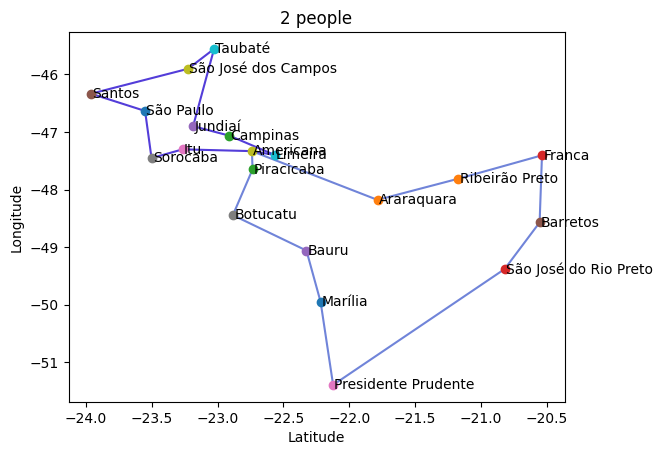

Total distance: 1815.3140987164343 (km)


In [ ]:
# New set of cities with their coordinates
city_coordinates_dict = {
      "São Paulo": (-23.550520, -46.633308),
    "Ribeirão Preto": (-21.169956, -47.809879),
    "Campinas": (-22.909938, -47.062633),
    "São José do Rio Preto": (-20.819000, -49.379700),
    "Bauru": (-22.324569, -49.058695),
    "Santos": (-23.960834, -46.333357),
    "Presidente Prudente": (-22.121944, -51.392500),
    "Sorocaba": (-23.501528, -47.452626),
    "São José dos Campos": (-23.223701, -45.900907),
    "Taubaté": (-23.026392, -45.555713),
    "Marília": (-22.217067, -49.950065),
    "Araraquara": (-21.784735, -48.178104),
    "Piracicaba": (-22.733878, -47.647604),
    "Franca": (-20.535206, -47.403938),
    "Jundiaí": (-23.185600, -46.897800),
    "Barretos": (-20.553135, -48.569768),
    "Itu": (-23.264712, -47.299999),
    "Botucatu": (-22.883504, -48.443375),
    "Americana": (-22.739131, -47.331210),
    "Limeira": (-22.566661, -47.397031)
}
sites = list(city_coordinates_dict.keys())
positions = city_coordinates_dict

# Function to calculate distance between two coordinates
def haversine(coord1, coord2):
    R = 6371  # Radius of the Earth in km
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Calculate distances between all pairs of cities
distances = {(i, j): haversine(positions[i], positions[j]) for i in sites for j in sites if i != j}

K = 2  # Number of salespeople

# Create the problem
prob = LpProblem("vehicle", LpMinimize)

# Indicator variable if site i is connected to site j in the tour
x = LpVariable.dicts('x', distances, 0, 1, LpBinary)

# Dummy variables to eliminate subtours
u = LpVariable.dicts('u', sites, 0, len(sites) - 1, LpInteger)

# The objective
cost = lpSum([x[(i, j)] * distances[(i, j)] for (i, j) in distances])
prob += cost

# Constraints
for k in sites:
    cap = 1 if k != 'Americana' else K
    # Inbound connection
    prob += lpSum([x[(i, k)] for i in sites if (i, k) in x]) == cap
    # Outbound connection
    prob += lpSum([x[(k, i)] for i in sites if (k, i) in x]) == cap

# Subtour elimination
N = len(sites) / K
for i in sites:
    for j in sites:
        if i != j and (i != 'Americana' and j != 'Americana') and (i, j) in x:
            prob += u[i] - u[j] <= (N) * (1 - x[(i, j)]) - 1

%time prob.solve()
print(LpStatus[prob.status])

non_zero_edges = [e for e in x if value(x[e]) != 0]

def get_next_site(parent):
    '''Helper function to get the next edge'''
    edges = [e for e in non_zero_edges if e[0] == parent]
    for e in edges:
        non_zero_edges.remove(e)
    return edges

tours = get_next_site('Americana')
tours = [[e] for e in tours]

for t in tours:
    while t[-1][1] != 'Americana':
        t.append(get_next_site(t[-1][1])[-1])

# Adicionando o ponto de partida ao final de cada rota
for t in tours:
    t.append(('Americana', t[0][0]))

for t in tours:
    print(' -> '.join([a for a, b in t]))

# Draw the tours
colors = [np.random.rand(3) for i in range(len(tours))]
for t, c in zip(tours, colors):
    for a, b in t:
        p1, p2 = positions[a], positions[b]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=c)

# Draw the map again
for s in positions:
    p = positions[s]
    plt.plot(p[0], p[1], 'o')
    plt.text(p[0] + .01, p[1], s, horizontalalignment='left', verticalalignment='center')

plt.title(f'{K} people' if K > 1 else '1 person')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

print('Total distance:', value(prob.objective), '(km)')




In [ ]:
# Draw the map using Folium
map_folium = Map(location=[-23.5505, -46.6333], zoom_start=10)  # Centralizar o mapa em São Paulo

# Add markers for each city
for city, coord in city_coordinates_dict.items():
    Marker(location=coord, popup=Popup(city)).add_to(map_folium)

# Add polylines for each tour
colors = ['red', 'blue']
for idx, tour in enumerate(tours):
    color = colors[idx % len(colors)]
    coordinates = [city_coordinates_dict[city] for city, _ in tour]
    PolyLine(locations=coordinates, color=color, weight=3, opacity=0.8).add_to(map_folium)

# Save the map as HTML file
map_folium.save("mapa_rotas_interativo.html")

# Display the map (for Jupyter notebooks)
map_folium

# Referencias

py2opt - https://github.com/pdrm83/py2opt/tree/master

Em otimização, o 2-opt é um algoritmo de busca local simples com um mecanismo especial de troca que se adapta bem para resolver o problema do caixeiro-viajante (Traveling Salesman Problem - TSP). O objetivo do 2-opt é melhorar uma solução inicial ao trocar duas arestas para reduzir a distância total percorrida. O processo consiste em selecionar duas arestas em uma rota e reverter a sub-rota entre essas arestas, criando uma nova rota potencialmente mais curta.

Este algoritmo é sensível ao ponto inicial de busca, ou seja, seus resultados finais podem variar dependendo da solução inicial fornecida. Diferentes pontos de partida podem levar a diferentes soluções locais ótimas, o que destaca a importância de escolher ou gerar um bom ponto de partida. Em muitos casos, é benéfico executar o 2-opt várias vezes com diferentes pontos iniciais e comparar os resultados para encontrar a melhor solução possível.

Além disso, o 2-opt é frequentemente usado em conjunto com outros algoritmos e heurísticas, como o algoritmo de vizinho mais próximo ou outras técnicas de busca local, para melhorar ainda mais a qualidade da solução. A simplicidade e a eficácia do 2-opt tornam-no uma escolha popular para resolver problemas de roteamento e otimização em diversas aplicações práticas.

Para melhor adaptabilidade com meu problema foi emplementada dentro da biblioteca um gerador de mapas para visualização da rota

In [ ]:
import random2
import time

from py2opt.solver import Solver


class RouteFinder:
    def __init__(self, distance_matrix, cities_names, iterations=5, writer_flag=False, method='py2opt', return_to_begin=False, verbose=True):
        self.distance_matrix = distance_matrix
        self.iterations = iterations
        self.return_to_begin = return_to_begin
        self.writer_flag = writer_flag
        self.cities_names = cities_names
        self.verbose = verbose

    def solve(self):
        start_time = round(time.time() * 1000)
        elapsed_time = 0
        iteration = 0
        best_distance = 0
        best_route = []
        best_distances = []

        while iteration < self.iterations:
            num_cities = len(self.distance_matrix)
            if self.verbose:
                print(round(elapsed_time), 'msec')
            initial_route = [0] + random2.sample(range(1, num_cities), num_cities - 1)
            if self.return_to_begin:
                initial_route.append(0)
            tsp = Solver(self.distance_matrix, initial_route)
            new_route, new_distance, distances = tsp.two_opt()

            if iteration == 0:
                best_distance = new_distance
                best_route = new_route
            else:
                pass

            if new_distance < best_distance:
                best_distance = new_distance
                best_route = new_route
                best_distances = distances

            elapsed_time = round(time.time() * 1000) - start_time
            iteration += 1

        if self.writer_flag:
            self.writer(best_route, best_distance, self.cities_names)

        if self.cities_names:
            best_route = [self.cities_names[i] for i in best_route]
            return best_distance, best_route
        else:
            return best_distance, best_route

    @staticmethod
    def writer(best_route, best_distance, cities_names):
        f = open("../results.txt", "w+")
        for i in best_route:
            f.write(cities_names[i])
            f.write("\n")
            print(cities_names[i])
        f.write(str(best_distance))
        f.close()

vrp - https://github.com/jwang0306/vehicle-routing-problem/tree/master

In [ ]:
from pulp import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
#a handful of sites
sites = ['Barcelona','Belgrade','Berlin','Brussels','Bucharest','Budapest','Copenhagen','Dublin','Hamburg','Istanbul','Kiev','London','Madrid','Milan','Moscow','Munich','Paris','Prague','Rome','Saint Petersburg','Sofia','Stockholm','Vienna','Warsaw']
# sites = ['Barcelona','Belgrade','Berlin','Brussels','Bucharest','Budapest','Copenhagen']
latlng = ['latitude', 'longitude']
position = pd.read_csv('./data/position.csv', index_col="City")
flighttime = pd.read_csv('./data/flight_time.csv', index_col="City")
distance = pd.read_csv('./data/distance.csv', index_col="City")
position.head(5)
# print(len(sites))
#make some positions (so we can plot this)
positions = dict( ( city, (position.loc[city, 'longitude'], position.loc[city, 'latitude']) ) for city in sites)
for s in positions:
    p = positions[s]
    plt.plot(p[0],p[1],'o')
    plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')

plt.gca().axis('off');
# get distanc between cities
distances = dict( ((s1,s2), distance.loc[s1, s2] ) for s1 in positions for s2 in positions if s1!=s2)
K = 4 #the number of sales people
#create the problme
prob=LpProblem("vehicle", LpMinimize)
#indicator variable if site i is connected to site j in the tour
x = LpVariable.dicts('x',distances, 0,1,LpBinary)
#dummy vars to eliminate subtours
u = LpVariable.dicts('u', sites, 0, len(sites)-1, LpInteger)
#the objective
cost = lpSum([x[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost
#constraints
for k in sites:
    cap = 1 if k != 'Berlin' else K
    #inbound connection
    prob+= lpSum([ x[(i,k)] for i in sites if (i,k) in x]) ==cap
    #outbound connection
    prob+=lpSum([ x[(k,i)] for i in sites if (k,i) in x]) ==cap

#subtour elimination
N=len(sites)/K
for i in sites:
    for j in sites:
        if i != j and (i != 'Berlin' and j!= 'Berlin') and (i,j) in x:
            prob += u[i] - u[j] <= (N)*(1-x[(i,j)]) - 1
%time prob.solve()
#prob.solve(GLPK_CMD(options=['--simplex']))
print(LpStatus[prob.status])
non_zero_edges = [ e for e in x if value(x[e]) != 0 ]

def get_next_site(parent):
    '''helper function to get the next edge'''
    edges = [e for e in non_zero_edges if e[0]==parent]
    for e in edges:
        non_zero_edges.remove(e)
    return edges
tours = get_next_site('Berlin')
tours = [ [e] for e in tours ]

for t in tours:
    while t[-1][1] !='Berlin':
        t.append(get_next_site(t[-1][1])[-1])
for t in tours:
    print(' -> '.join([ a for a,b in t]+['Berlin']))
totalTime = 0;
for t in tours:
    time = 0
    for i in range(0, len(t)):
        time += flighttime.loc[t[i][0], t[i][1]]
#         print(flighttime.loc[t[i][0], t[i][1]])
#     print(time)
    if time > totalTime:
        totalTime = time
print(totalTime)
#draw the tours
colors = [np.random.rand(3) for i in range(len(tours))]
for t,c in zip(tours,colors):
    for a,b in t:
        p1,p2 = positions[a], positions[b]
        plt.plot([p1[0],p2[0]],[p1[1],p2[1]], color=c)

#draw the map again
for s in positions:
    p = positions[s]
    plt.plot(p[0],p[1],'o')
    plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')

plt.title('%d '%K + 'people' if K > 1 else 'person')
plt.xlabel('latitude')
plt.ylabel('longitude')
# plt.gca().axis('off')
plt.show()
print('Longest time spent:', totalTime, '(min)')
print('Total distance:', value(prob.objective), '(km)')

FileNotFoundError: [Errno 2] No such file or directory: './data/position.csv'

In [ ]:
#solver rota fechada

import random2
import time
from folium import Map, PolyLine, LayerControl, Marker, Popup
from py2opt.solver import Solver
import geopy.distance as geodist
import numpy as np

class RouteFinder:
    def __init__(self, distance_matrix, city_coordinates, cities_names, iterations=5, writer_flag=False, method='py2opt', return_to_begin=False, verbose=True):
        self.distance_matrix = distance_matrix
        self.iterations = iterations
        self.return_to_begin = return_to_begin
        self.writer_flag = writer_flag
        self.cities_names = cities_names
        self.verbose = verbose
        self.distances_per_iteration = []  # List to store distances for plotting
        self.city_coordinates = city_coordinates  # City coordinates (latitude, longitude)
        self.all_routes = []  # List to store routes from each iteration

    def solve(self):
        start_time = round(time.time() * 1000)
        elapsed_time = 0
        iteration = 0
        best_distance = 0
        best_route = []

        while iteration < self.iterations:
            num_cities = len(self.distance_matrix)
            if self.verbose:
                print(round(elapsed_time), 'msec')
            initial_route = [0] + random2.sample(range(1, num_cities), num_cities - 1) + [0]
            tsp = Solver(self.distance_matrix, initial_route)
            new_route, new_distance, distances = tsp.two_opt()

            if iteration == 0:
                best_distance = new_distance
                best_route = new_route

            if new_distance < best_distance:
                best_distance = new_distance
                best_route = new_route

            self.all_routes.append(new_route.copy())  # Store route for each iteration
            self.distances_per_iteration.append(best_distance)
            elapsed_time = round(time.time() * 1000) - start_time
            iteration += 1

        if self.writer_flag:
            self.writer(best_route, best_distance, self.cities_names)

        if self.cities_names:
            best_route = [self.cities_names[i] for i in best_route]
        return best_distance, best_route

    @staticmethod
    def writer(best_route, best_distance, cities_names):
        with open("../results.txt", "w+") as f:
            for i in best_route:
                f.write(cities_names[i])
                f.write("\n")
                print(cities_names[i])
            f.write(str(best_distance))

    def create_initial_map(self):
        # Assuming city coordinates are in latitude, longitude format in self.city_coordinates
        starting_latitude = self.city_coordinates[0][0]
        starting_longitude = self.city_coordinates[0][1]
        m = Map(location=[starting_latitude, starting_longitude], zoom_start=8)
        return m

    def plot_best_route(self):
        m = self.create_initial_map()

        # Destacar a melhor rota
        best_route = self.all_routes[-1]
        best_polyline = PolyLine(
            locations=[[self.city_coordinates[j][0], self.city_coordinates[j][1]] for j in best_route],
            color='red',
            weight=3,
            opacity=0.8,
            tooltip=f'Best Route: Distance {self.distances_per_iteration[-1]:.2f} km'
        )
        best_polyline.add_to(m)

        # Adicionar marcadores para cada cidade
        for name, coord in zip(self.cities_names, self.city_coordinates):
            Marker(
                location=(coord[0], coord[1]),
                popup=Popup(name, parse_html=True)
            ).add_to(m)

        LayerControl().add_to(m)
        return m


In [ ]:
pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 29.7 MB/s eta 0:00:00


<ipython-input-4-889077425e39>:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf['geometry'].centroid


Infeasible


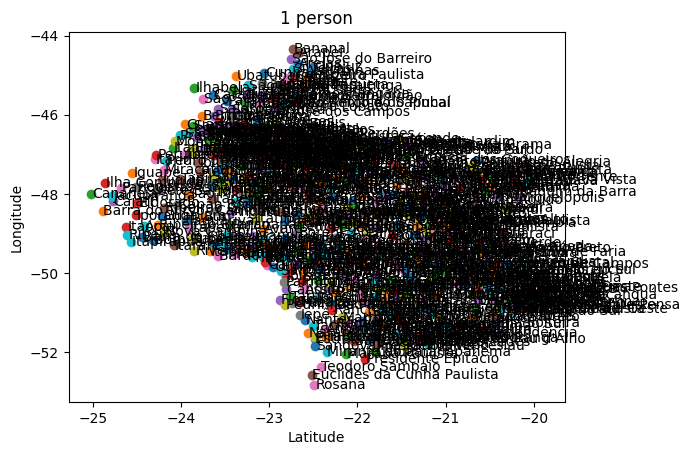

Total distance: None (km)


In [ ]:
from pulp import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import geopandas as gpd
from joblib import Parallel, delayed

# Carregar o GeoDataFrame a partir do arquivo GeoJSON
gdf = gpd.read_file('/content/geojs-35-mun.json')

# Calcular o centróide de cada geometria
gdf['centroid'] = gdf['geometry'].centroid

# Extrair nomes das cidades e coordenadas dos centroides
city_names = gdf['name'].to_list()
city_coords = [(point.y, point.x) for point in gdf['centroid']]

# Criar dicionário de coordenadas das cidades
city_coordinates_dict = {city_names[i]: city_coords[i] for i in range(len(city_names))}

sites = list(city_coordinates_dict.keys())
positions = city_coordinates_dict

# Function to calculate distance between two coordinates using NumPy for vectorization
def haversine_np(coord1, coord2):
    R = 6371  # Radius of the Earth in km
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Parallelize distance calculations using joblib
def calculate_distances_parallel(sites, positions):
    distances = {}
    def compute_distance(i, j):
        if i != j:
            distances[(i, j)] = haversine_np(positions[i], positions[j])

    Parallel(n_jobs=-1)(delayed(compute_distance)(i, j) for i in sites for j in sites)
    return distances

distances = calculate_distances_parallel(sites, positions)

K = 1  # Number of salespeople

# Create the problem
prob = LpProblem("vehicle", LpMinimize)

# Indicator variable if site i is connected to site j in the tour
x = LpVariable.dicts('x', distances, 0, 1, LpBinary)

# Dummy variables to eliminate subtours
u = LpVariable.dicts('u', sites, 0, len(sites) - 1, LpInteger)

# The objective
cost = lpSum([x[(i, j)] * distances[(i, j)] for (i, j) in distances])
prob += cost

# Constraints
for k in sites:
    cap = 1 if k != 'Americana' else K
    # Inbound connection
    prob += lpSum([x[(i, k)] for i in sites if (i, k) in x]) == cap
    # Outbound connection
    prob += lpSum([x[(k, i)] for i in sites if (k, i) in x]) == cap

# Subtour elimination
N = len(sites) / K
for i in sites:
    for j in sites:
        if i != j and (i != 'Americana' and j != 'Americana') and (i, j) in x:
            prob += u[i] - u[j] <= (N) * (1 - x[(i, j)]) - 1

# Use more efficient solvers if available (like CBC or Gurobi)
prob.solve(PULP_CBC_CMD())

print(LpStatus[prob.status])

non_zero_edges = [e for e in x if value(x[e]) != 0]

def get_next_site(parent):
    '''Helper function to get the next edge'''
    edges = [e for e in non_zero_edges if e[0] == parent]
    for e in edges:
        non_zero_edges.remove(e)
    return edges

tours = get_next_site('Americana')
tours = [[e] for e in tours]

for t in tours:
    while t[-1][1] != 'Americana':
        t.append(get_next_site(t[-1][1])[-1])

# Adicionando o ponto de partida ao final de cada rota
for t in tours:
    t.append(('Americana', t[0][0]))

for t in tours:
    print(' -> '.join([a for a, b in t]))

# Draw the tours
colors = [np.random.rand(3) for i in range(len(tours))]
for t, c in zip(tours, colors):
    for a, b in t:
        p1, p2 = positions[a], positions[b]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=c)

# Draw the map again
for s in positions:
    p = positions[s]
    plt.plot(p[0], p[1], 'o')
    plt.text(p[0] + .01, p[1], s, horizontalalignment='left', verticalalignment='center')

plt.title(f'{K} people' if K > 1 else '1 person')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

print('Total distance:', value(prob.objective), '(km)')
